In [16]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib
import h5py as h5
import time
import os

def read_dim_fromfile(name):
    file = h5.File(name, "r")
    Nx = int(file.get("LBE3D").attrs["lbe_sx"][0])
    Ny = int(file.get("LBE3D").attrs["lbe_sy"][0])
    Nz = int(file.get("LBE3D").attrs["lbe_sz"][0])
    dt = int(file.get("LBE3D").attrs["lbe_diag_nsteps"][0])
    t  = int(file.get("LBE3D").attrs["lbe_steps"][0])
    steps = int(t / dt)
    print("Nx Ny Nz = %d %d %d"%(Nx,Ny,Nz))
    print("t : %d;  dt : %d;  steps : %d"%(t,dt,steps))
    return Nx,Ny,Nz,t,dt,steps
    file.close()

def read_field_fromfile(name, field):
    file = h5.File(name, "r")
    name_field="/LBE3D/"+field
    f = np.zeros((Nx,Ny,Nz))
    f[:,:,:] = file.get(str(name_field))[...]
    file.close()
    return f

def swap_XZ(Nx,Nz):
    return Nz,Nx;

test = "SCMP_LAPLACE_SHEARSTRESSTENSOR/"
# test = "SCMP_COUETTE_SHEARSTRESSTENSOR/"

direc = "/home/matti/programming/lbe-direct/src/tests/"+test
direcRUN = direc+"RUN/"
print("Creation of the RUN/ folder time: "+time.ctime(os.path.getctime(direcRUN)))

name=direcRUN+"density_t.0.h5"
Nx,Ny,Nz,tf,dt,steps = read_dim_fromfile(name)
#Nx,Nz = swap_XZ(Nx,Nz);

def comp_nu(tau):
    return (tau-0.5)/3.0
tau1=1
tau2=1
nu1=comp_nu(tau1)
nu2=comp_nu(tau2)

rho1 = np.zeros((steps,Nx,Ny,Nz))
rho2 = np.zeros((steps,Nx,Ny,Nz))
vx   = np.zeros((steps,Nx,Ny,Nz))
vy   = np.zeros((steps,Nx,Ny,Nz))
vz   = np.zeros((steps,Nx,Ny,Nz))
vmag = np.zeros((steps,Nx,Ny,Nz))
# SSTyz = np.zeros((steps,Nx,Ny,Nz))
for i in range(1,steps):
    t = i*dt
    name=direcRUN+"density_t.%d.h5"%t
    rho1[i,:,:,:] = read_field_fromfile(name,"rho1")
    rho2[i,:,:,:] = read_field_fromfile(name,"rho2")
    name=direcRUN+"velocity_t.%d.h5"%t
    vx[i,:,:,:]   = read_field_fromfile(name,"vx")
    vy[i,:,:,:]   = read_field_fromfile(name,"vy")
    vz[i,:,:,:]   = read_field_fromfile(name,"vz")
    name=direcRUN+"SST_yz.%d.h5"%t
    # SSTyz[i,:,:,:] = read_field_fromfile(name,"SST_yz")
vmag = np.sqrt(vx*vx + vy*vy + vz*vz)
rhoN = (rho1-rho2)/(rho1+rho2)

# sp_curr_v = np.zeros((steps,Nz,4))
# sp_curr_v[:,:,0] = np.max(vx[:,:,:,:], axis=(1, 2))
# sp_curr_v[:,:,1] = np.max(vy[:,:,:,:], axis=(1, 2))
# sp_curr_v[:,:,2] = np.max(vz[:,:,:,:], axis=(1, 2))
# sp_curr_v[:,:,3] = np.sqrt(sp_curr_v[:,:,0]**2 + sp_curr_v[:,:,1]**2 + sp_curr_v[:,:,2]**2)

#default value found for the used settings
sigma = 0.024
#read sigma for the laplace test
if test=='SCMP_LAPLACE_SHEARSTRESSTENSOR/':
    lap = np.loadtxt(direc+"laplace_clean.dat")
    print(lap[:,-1])
    sigma = lap[-1,-1]
print("sigma = %f"%sigma)

# components of the simmetrical tensors:
# 0: xx; 1: xy; 2: xz
# _: yx; 3: yy; 4: yz
# _: zx; _: zy; 5: zz

#read SST
SST = np.zeros((steps,Nz,6))
with open(direc+"sst_xx.dat", 'r') as f:
    SST[:,:,0] = np.loadtxt(f)
with open(direc+"sst_xy.dat", 'r') as f:
    SST[:,:,1] = np.loadtxt(f)
with open(direc+"sst_xz.dat", 'r') as f:
    SST[:,:,2] = np.loadtxt(f)
with open(direc+"sst_yy.dat", 'r') as f:
    SST[:,:,3] = np.loadtxt(f)
with open(direc+"sst_yz.dat", 'r') as f:
    SST[:,:,4] = np.loadtxt(f)
with open(direc+"sst_zz.dat", 'r') as f:
    SST[:,:,5] = np.loadtxt(f)
    
gradvsum = np.zeros((steps,Nz,6))
couette_name = ''
if test=='SCMP_COUETTE_SHEARSTRESSTENSOR/':
    couette_name = ' (average)'
    _rho1=0.18
    _rho2=1.18 #1.18
    print('couette')
    with open(direc+"grad_v_sum.dat", 'r') as f:
        gradvsum[:,1:-1,4] = np.loadtxt(f) * (_rho1*nu1+_rho2*nu2)

def deriv5(f,x):
    return ( (-f[:,x+2] + 8.0*f[:,x+1] - 8.0*f[:,x-1] + f[:,x-2])/12.0 )
def deriv3(f,x):
    return ( (f[:,x+1] - f[:,x-1])/2.0 )
deriv = deriv3

Nx2 = int(Nx/2)
Ny2 = int(Ny/2)
n     = np.zeros((steps,Nz,3))
dv_dx = np.zeros((steps,Nz,3))
dv_dy = np.zeros((steps,Nz,3))
dv_dz = np.zeros((steps,Nz,3))
# SSTyz_ava = np.zeros((steps,Nz))
# DrhoN_mod = np.zeros((steps,Nz))
for i in range(1,Nz-1):
    #compute rho_N derivative for X=Nx/2, Y=Ny/2, use 5 point derivative
    n[:,i,0] = deriv(rhoN[:,:,Ny2,i]  , Nx2); #derivative along X
    n[:,i,1] = deriv(rhoN[:,Nx2,:,i]  , Ny2); #derivative along Y
    n[:,i,2] = deriv(rhoN[:,Nx2,Ny2,:], i);   #derivative along Z
    #normalize to get n
    # th = np.zeros((np.shape(n[:,0,0]))) #+ 1e-1
    # DrhoN_mod[:,i] = np.maximum(np.sqrt(n[:,i,0]**2 + n[:,i,1]**2 + n[:,i,2]**2),th)
    # DrhoN_mod[:,i] = np.sqrt(n[:,i,0]**2 + n[:,i,1]**2 + n[:,i,2]**2)
    # n[:,i,0] /= DrhoN_mod[:,i]
    # n[:,i,1] /= DrhoN_mod[:,i]
    # n[:,i,2] /= DrhoN_mod[:,i]
    # compute dervatives of vx,vy,vz in all directions
    dv_dx[:,i,0] = deriv(vx[:,:,Ny2,i], Nx2) #derivative along X
    dv_dx[:,i,1] = deriv(vy[:,:,Ny2,i], Nx2)
    dv_dx[:,i,2] = deriv(vz[:,:,Ny2,i], Nx2)
    dv_dy[:,i,0] = deriv(vx[:,Nx2,:,i], Ny2) #derivative along Y
    dv_dy[:,i,1] = deriv(vy[:,Nx2,:,i], Ny2)
    dv_dy[:,i,2] = deriv(vz[:,Nx2,:,i], Ny2)
    dv_dz[:,i,0] = deriv(vx[:,Nx2,Ny2,:], i) #derivative along X
    dv_dz[:,i,1] = deriv(vy[:,Nx2,Ny2,:], i)
    dv_dz[:,i,2] = deriv(vz[:,Nx2,Ny2,:], i)
    # SSTyz_ava[:,i] = np.sum(SSTyz[:,:,:,i], axis=(1,2))/(Nx*Ny)

# cosi filtro fuori le normali lontane dall' interfaccia (che hanno il modulo di DrhoN piu' piccolo)
# for i in range(steps):
#     filt = np.max(DrhoN_mod[i,:])*0.1
#     n[i,DrhoN_mod[i,:]<filt,:] = 0.0 

# components of the simmetrical tensor:
# 0: xx; 1: xy; 2: xz
# _: yx; 3: yy; 4: yz
# _: zx; _: zy; 5: zz

# P1 = (nu1*rho1+nu2*rho2)*(dvi/dxj + dvj/dxi)
P1 = np.zeros((steps,Nz,6))
rhonu = (nu1*rho1[:,Nx2,Ny2,:] + nu2*rho2[:,Nx2,Ny2,:])
P1[:,:,0] = rhonu * (dv_dx[:,:,0] * 2) 
P1[:,:,1] = rhonu * (dv_dy[:,:,0] + dv_dx[:,:,1])
P1[:,:,2] = rhonu * (dv_dz[:,:,0] + dv_dx[:,:,2])
P1[:,:,3] = rhonu * (dv_dy[:,:,1] * 2)
P1[:,:,4] = rhonu * (dv_dz[:,:,1] + dv_dy[:,:,2])
P1[:,:,5] = rhonu * (dv_dz[:,:,2] * 2)

# P2 = sigma*(identity - n (tensor product) n)
P2 = np.zeros((steps,Nz,6))
P2[:,:,0] = (1 - n[:,:,0]*n[:,:,0]) * sigma
P2[:,:,1] = (  - n[:,:,0]*n[:,:,1]) * sigma
P2[:,:,2] = (  - n[:,:,0]*n[:,:,2]) * sigma
P2[:,:,3] = (1 - n[:,:,1]*n[:,:,1]) * sigma
P2[:,:,4] = (  - n[:,:,1]*n[:,:,2]) * sigma
P2[:,:,5] = (1 - n[:,:,2]*n[:,:,2]) * sigma


Creation of the RUN/ folder time: Tue Mar 18 19:45:36 2025
Nx Ny Nz = 128 128 128
t : 20000;  dt : 500;  steps : 40
[0.0322778 0.0160998 0.0290451 0.0240114 0.0180774 0.0244109 0.0241259
 0.020364  0.0228324 0.0238303 0.0219243 0.0226463 0.0235841 0.0227868
 0.0228881 0.0235097 0.0232675 0.0232208 0.0235802 0.0235706 0.0235285
 0.0237244 0.0237886 0.0237789 0.0238867 0.0239611 0.0239772 0.0240436
 0.0241101 0.0241416 0.0241907 0.0242472 0.0242852 0.024327  0.0243745
 0.0244129 0.0244498 0.0244895 0.0245243 0.0245563]
sigma = 0.024556


/tmp/ipykernel_11109/1921097979.py:69: RuntimeWarning: invalid value encountered in divide
  rhoN = (rho1-rho2)/(rho1+rho2)


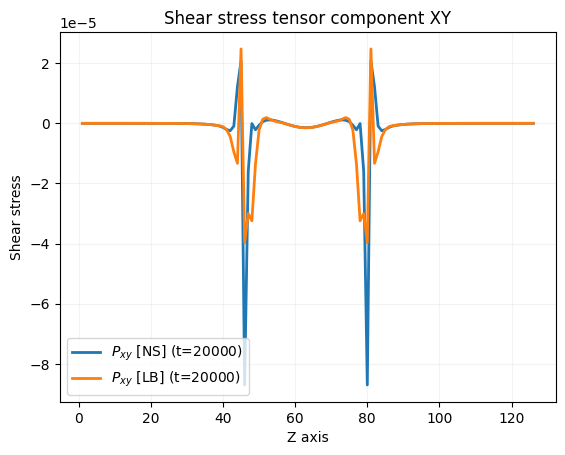

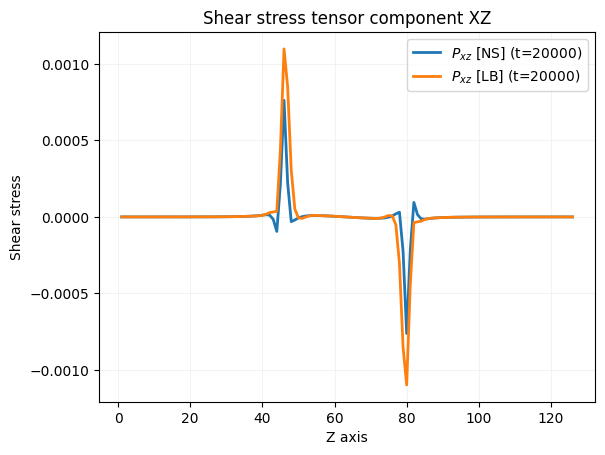

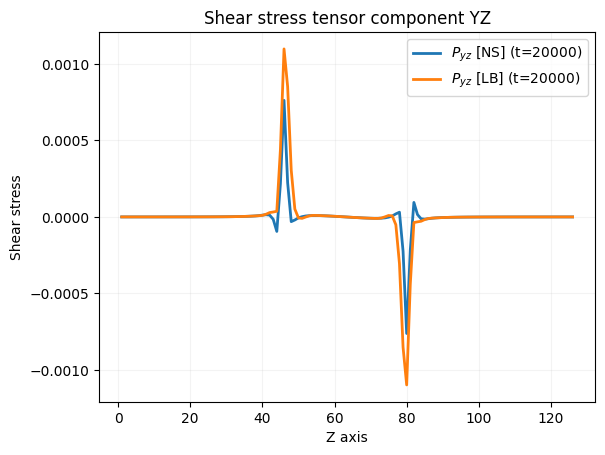

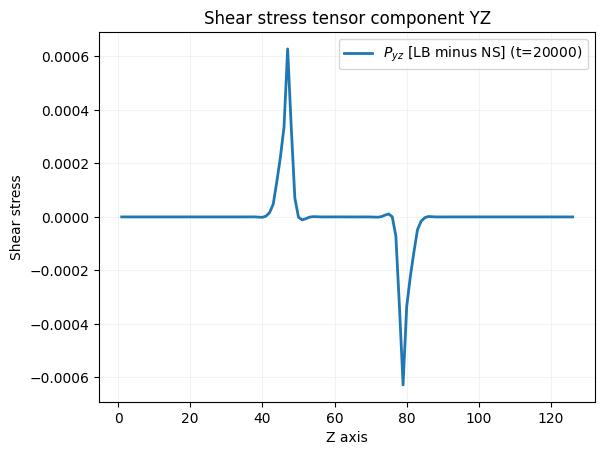

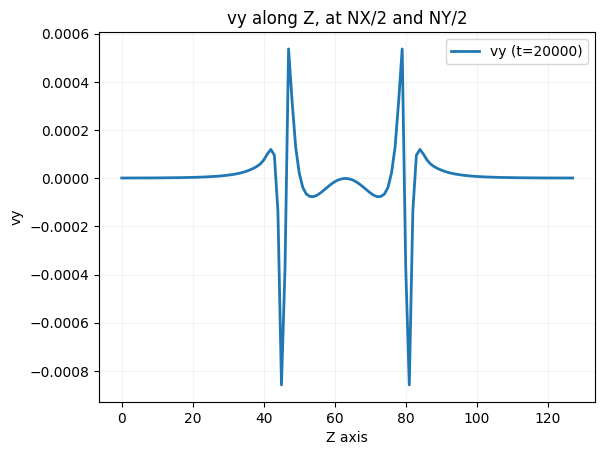

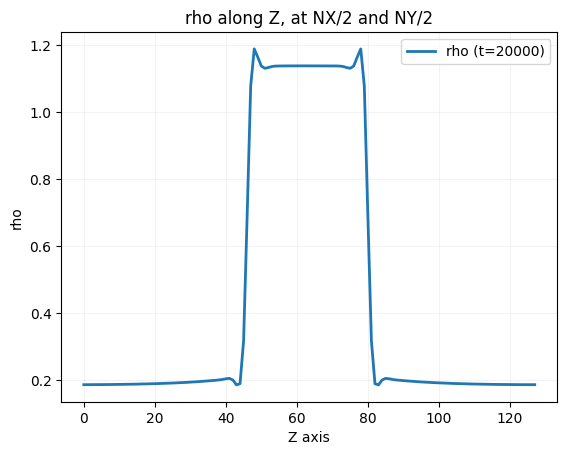

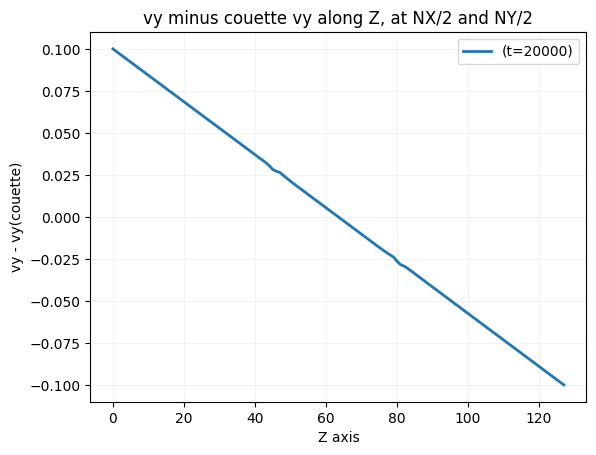

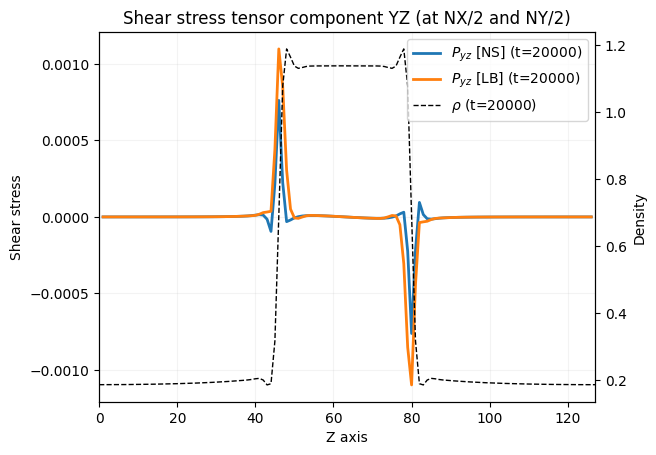

In [31]:
SAVE = 1
save_dir = "/home/matti/Pictures/images_sst/"

mark = 'none'
lw=2

SHOW_VLINE = 0
SHOW_TICKS = 0

ascisse  = np.linspace(1,Nz-2,Nz-2)
ascisseT = np.linspace(0,Nz-1,Nz)

pltlist = [0,5,10,14,19]
pltlist = [steps-1]
# pltlist = [steps]
# pltlist = [0]



P=P1+P2
# P=gradvsum

def plottino(j,f1,f2,lab,title,savename):
    _ = plt.figure(j)
    for i in pltlist:
        _ = plt.plot(ascisse,f1[i,:], marker=mark,markersize=10,linewidth=lw, label=lab+' [NS] (t=%d)'%(i*dt+dt))
        _ = plt.plot(ascisse,f2[i,:], marker=mark,markersize=10,linewidth=lw, label=lab+' [LB] (t=%d)'%(i*dt+dt))
    if SHOW_VLINE:
        _ = plt.vlines((Nz-1)/2,min(f1[-1,:]),max(f1[-1,:]),color='black',linestyle='--',linewidth=1)
    _ = plt.title('Shear stress tensor component '+title+couette_name)
    _ = plt.ylabel('Shear stress')
    _ = plt.xlabel('Z axis')
    if SHOW_TICKS:
        _ = plt.xticks(ascisseT)
    _ = plt.legend()
    _ = plt.grid(alpha=0.15)
    if SAVE:
        _ = plt.savefig(save_dir+savename+".png", bbox_inches='tight', dpi=300, format='png')

plottino(1,P[:,1:-1,1],SST[:,1:-1,1], r'$P_{xy}$', 'XY', 'Pxy')
plottino(2,P[:,1:-1,2],SST[:,1:-1,2], r'$P_{xz}$', 'XZ', 'Pxy')
plottino(3,P[:,1:-1,4],SST[:,1:-1,4], r'$P_{yz}$', 'YZ', 'Pyz')

# CHECK HDF5 OUTPUT
# _ = plt.figure(444)
# for i in pltlist:
#     _ = plt.plot(ascisse,P[-1,1:-1,4], marker='.',markersize=10,linewidth=1, label=r'$P_{xy}$ [NS] (t=%d)'%(i*dt+dt))
#     _ = plt.plot(ascisse,SST[-1,1:-1,4], marker='.',markersize=10,linewidth=1, label=r'$P_{xy}$ [LB] (t=%d)'%(i*dt+dt))
#     _ = plt.plot(ascisse,SSTyz_ava[-1,1:-1], marker='.',markersize=10,linewidth=1, label=r'$P_{xy}$ [H5LB] (t=%d)'%(i*dt+dt))
# _ = plt.title('Shear stress tensor component YZ')
# _ = plt.ylabel('Shear stress')
# _ = plt.xlabel('Z axis')
# _ = plt.xticks(ascisseT)
# _ = plt.legend()
# _ = plt.grid(alpha=0.15)
    
_ = plt.figure(4)
for i in pltlist:
    _ = plt.plot(ascisse,SST[i,1:-1,4] - P[i,1:-1,4], marker=mark,markersize=10,linewidth=lw, label=r'$P_{yz}$ [LB minus NS] (t=%d)'%(i*dt+dt))
if SHOW_VLINE:
    _ = plt.vlines((Nz-1)/2,-2e-4,2e-4,color='black',linestyle='--',linewidth=1)
_ = plt.title('Shear stress tensor component YZ'+couette_name)
_ = plt.ylabel('Shear stress')
_ = plt.xlabel('Z axis')
if SHOW_TICKS:
    _ = plt.xticks(ascisseT)
_ = plt.legend()
_ = plt.grid(alpha=0.15)
if SAVE:
    _ = plt.savefig(save_dir+"Pyz_diff.png", bbox_inches='tight', dpi=300, format='png')
    
# _ = plt.figure(5)
# _ = plt.plot(sp_curr_v[i,:,3], label=r'vel max, magnitude')
# _ = plt.title('Maximum velocity magnitude along Z')
# _ = plt.ylabel('v')
# _ = plt.xlabel('Z axis')
# _ = plt.legend()

def plotplotplot(i, f, lab, name, savename):
    _ = plt.figure(i)
    for i in pltlist:
        _ = plt.plot(ascisseT, f[i,:], marker=mark,markersize=10,linewidth=lw, label=lab+' (t=%d)'%(i*dt+dt))
    _ = plt.title(name)
    if SHOW_TICKS:
        _ = plt.xticks(ascisseT)
    if SHOW_VLINE:
        _ = plt.vlines((Nz-1)/2,min(f[i,:]),max(f[i,:]),color='black',linestyle='--',linewidth=1)
    _ = plt.ylabel(lab)
    _ = plt.xlabel('Z axis')
    _ = plt.legend()
    _ = plt.grid(alpha=0.15)
    if SAVE:
        _ = plt.savefig(save_dir+savename+".png", bbox_inches='tight', dpi=300, format='png')

plotplotplot(9,vy[:,Nx2,Ny2,:],'vy','vy along Z, at NX/2 and NY/2','vy')
plotplotplot(10,rho1[:,Nx2,Ny2,:],'rho','rho along Z, at NX/2 and NY/2','rho')


th_couette = np.linspace(-0.1,0.1,len(vy[-1,:]))
_ = plt.figure(100)
ff = vy[-1,Nx2,Ny2,:]-th_couette
_ = plt.plot(ascisseT, ff, marker=mark,markersize=10,linewidth=lw, label='(t=%d)'%(i*dt+dt))
_ = plt.title('vy minus couette vy along Z, at NX/2 and NY/2')
if SHOW_TICKS:
    _ = plt.xticks(ascisseT)
if SHOW_VLINE:
    _ = plt.vlines((Nz-1)/2,min(ff),max(ff),color='black',linestyle='--',linewidth=1)
_ = plt.ylabel('vy - vy(couette)')
_ = plt.xlabel('Z axis')
_ = plt.legend()
_ = plt.grid(alpha=0.15)
if SAVE:
    _ = plt.savefig(save_dir+"vy_inus_vycouette.png", bbox_inches='tight', dpi=300, format='png')

fig, ax1 = plt.subplots() 
for i in pltlist:
    _ = ax1.plot(ascisse,P[-1,1:-1,4], marker=mark,markersize=10,linewidth=lw,label=r'$P_{yz}$ [NS] (t=%d)'%(i*dt+dt))
    _ = ax1.plot(ascisse,SST[-1,1:-1,4], marker=mark,markersize=10,linewidth=lw, label=r'$P_{yz}$ [LB] (t=%d)'%(i*dt+dt))
_ = ax1.set_title('Shear stress tensor component YZ (at NX/2 and NY/2)')
_ = ax1.set_ylabel('Shear stress')
_ = ax1.set_xlabel('Z axis')
_ = ax1.set_xlim((ascisseT[0],ascisseT[-1]))
ax2 = ax1.twinx()
_ = ax2.plot(ascisseT,rho1[-1,Nx2,Ny2,:],marker=mark,markersize=10,linewidth=1,linestyle='--', color='black', label=r'$\rho$ (t=%d)'%(i*dt+dt))
_ = ax2.set_ylabel('Density')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2)#, loc="center right")
_ = ax1.grid(True, alpha=0.15)
if SAVE:
    _ = plt.savefig(save_dir+"YZ_dens.png", bbox_inches='tight', dpi=300, format='png')